[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/git-sunao/path-integral/blob/main/notebooks/dev08.ipynb)

In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jacobian
from getdist import MCSamples, plots

from tqdm import tqdm

import sys
sys.path.append("../")

from pldflow import plflow

import os
import jax
smoke_test = ('CI' in os.environ)
%matplotlib inline
cpu_device = jax.devices('cpu')[0]

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# See Eq (11) https://arxiv.org/pdf/astro-ph/0305055
def psi(x):
    return jnp.log(x)

def phi(y):
    xm = (y+jnp.sqrt(y**2 + 4.0))/2.0
    o = (xm-y)**2/2.0 - jnp.log(xm)
    return o

class Fresnel(plflow.PicardLefschetzModelBaseClass):
    ndim = 1
    def action_s(self, z, y, w=1):
        geo = jnp.dot(z-y,z-y)/2.0
        zs = jnp.dot(z,z)**0.5
        ys = jnp.dot(y,y)**0.5
        pot = -psi(zs) + phi(ys)
        return -1j * w * (geo + pot)

# Debugging

In [5]:
fresnel = Fresnel()
fresnel.rescale_velocity = False

In [6]:
n_samples = 200
# integral variable
x1 = jnp.linspace(-5, 5, n_samples)
x2 = jnp.zeros((n_samples, fresnel.ndim-1))
x  = jnp.array([x1, *x2.T]).T
# parameter
y  = jnp.zeros(fresnel.ndim)
# flow time
t = jnp.linspace(0, 0.4, 100)

In [7]:
# Using jax.jit makes the second ans later function calls faster
%time j = fresnel.vflow_jacobian(x, t, y=y, uselast=True)
%time j = fresnel.vflow_jacobian(x, t, y=y, uselast=True)

CPU times: user 4.19 s, sys: 355 ms, total: 4.54 s
Wall time: 4 s
CPU times: user 4.93 ms, sys: 668 µs, total: 5.6 ms
Wall time: 2.39 ms


In [8]:
w = 5.0

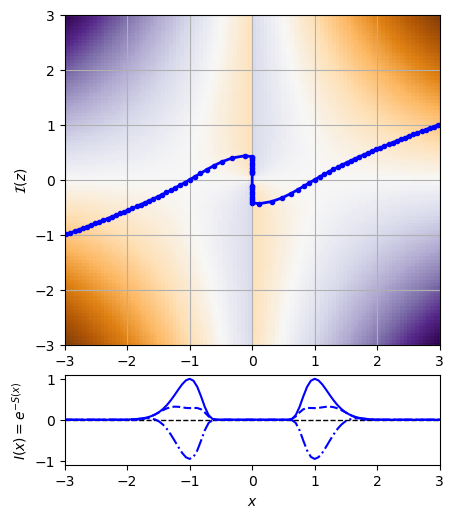

In [9]:
y = jnp.array([0.0])
t = jnp.linspace(0, 0.4/w, 100)
fig, axes = fresnel._plot1d_template()
fresnel.plot1d_action_map(100, y=y, w=w, fig=fig, axes=axes, shading='auto')
x = jnp.linspace(-3,3,100).reshape(-1,fresnel.ndim)
fresnel.plot1dgif('pointlens.gif', x, t=t, y=y, w=w, fig=fig, axes=axes, dpi=150)
plt.show()

## 1D

In [ ]:
fresnel = Fresnel(ndim=1)
t = jnp.linspace(0, 0.4/w, 100)

priors = {'x':(-5,5,fresnel.ndim), 'y':(-5,5,fresnel.ndim), 'w':w}
sampler = plflow.HMCSampler(fresnel, priors)
sampler.sample(num_samples=2000, t=t, seed=1, num_chains=4)

/Users/sugiyamasunao/Documents/projects/path-integral/notebooks/../pldflow/plflow.py:811: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
sample:  37%|███▋      | 919/2500 [23:17<1:07:54,  2.58s/it, 1023 steps of size 5.17e-04. acc. prob=0.90]

Removed no burn in


<Figure size 400x400 with 0 Axes>

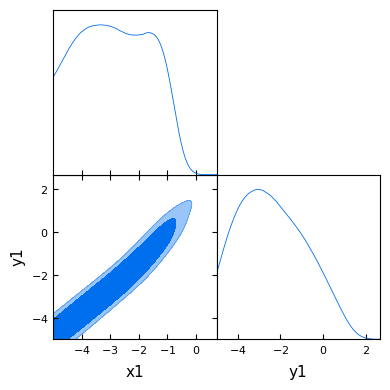

In [78]:
mcs = sampler.get_samples(format=MCSamples)

g = plots.get_single_plotter(ratio=1, width_inch=4)
g.triangle_plot(mcs, ['x1', 'y1'], filled=True)
plt.show()

Normalizing flow training

Training MAF:  56%|█████▋    | 563/1000 [00:45<00:35, 12.40it/s]


Early stopping at step 564 with best loss -0.08013204485177994


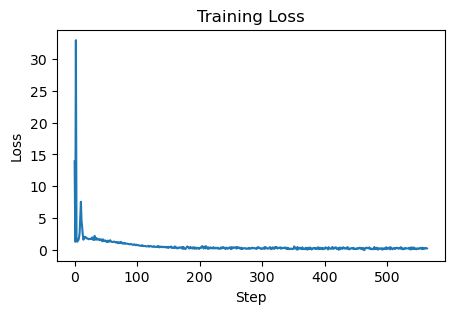

In [79]:
maf = plflow.MAFModel(sampler, process=True)

maf.build(hidden_dims=[128]*4, n_transforms=12)
maf.train(n_steps=1_000, batch_size=128, patience=100)
maf.plot_loss()

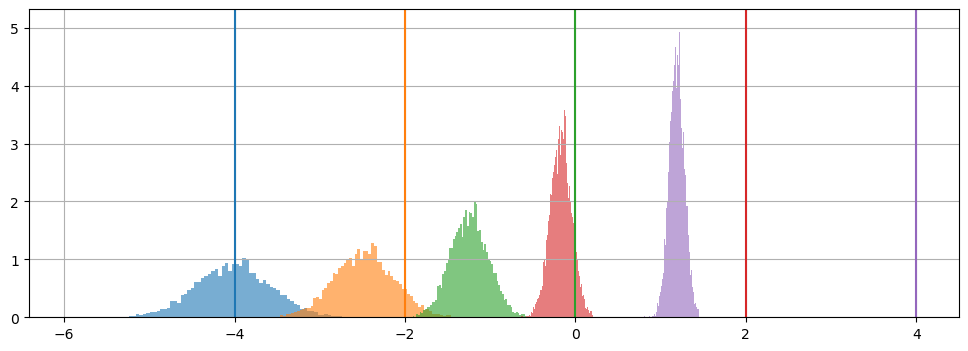

In [80]:
plt.figure(figsize=(12, 4))
for i, _y in enumerate([-4.0, -2.0, 0.0, 2.0, 4.0]):
    y   = jnp.array([_y]+[0.0]*(fresnel.ndim-1))
    x, lnp   = maf.sample_and_log_prob(y, num_samples=5000, seed=5)
    a = jnp.argsort(x[:,0])
    plt.hist(x[a,0], bins=80, density=True, color=f'C{i}', alpha=0.6)
    plt.axvline(y[0], color=f'C{i}')
plt.grid()
plt.show()

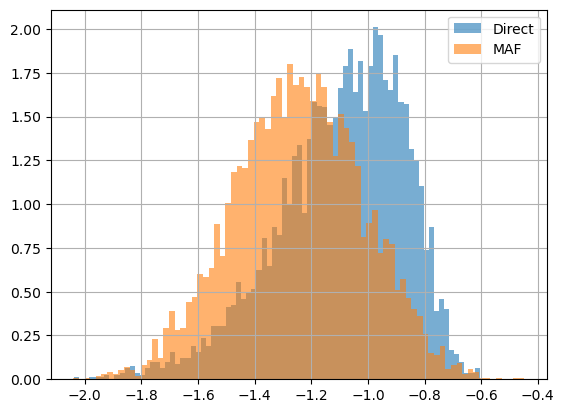

In [ ]:
priors = {'x':(-5,5,fresnel.ndim), 'y':jnp.array([0.0]), 'w':w}
sampler2 = plflow.HMCSampler(fresnel, priors)
sampler2.sample(num_samples=1000, num_chains=4, seed=1, t=t)

samples_dir = sampler2.get_samples(format=jnp.array)
samples_maf = maf.sample(context=jnp.array([0.0]), num_samples=5000, seed=0)

plt.hist(samples_dir[:,0], bins=80, density=True, alpha=0.6, label='Direct')
plt.hist(samples_maf[:,0], bins=80, density=True, alpha=0.6, label='MAF')
plt.grid()
plt.legend()
plt.show()

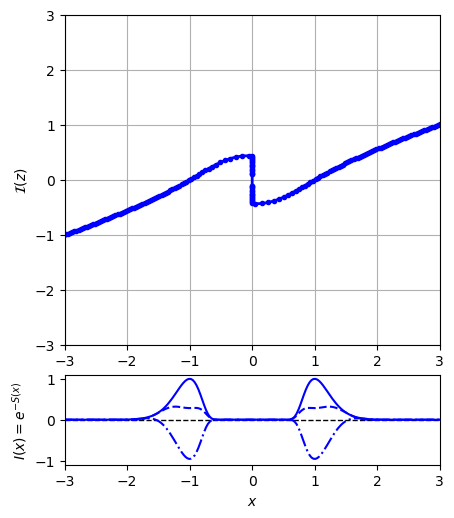

In [90]:
fresnel.plot1dgif('temp.gif', jnp.linspace(-3,3,200).reshape(-1, 1), t=t, y=jnp.array([0.0]), w=w)
plt.show()

Evaluate the integral

In [21]:
def perform(y, num_samples=1_000):
    x, lnp = maf.sample_and_log_prob(y, num_samples=num_samples, seed=0)
    Z, dZ  = fresnel.integrate(x, lnp, t, y=y, w=w, error=True)
    return Z, dZ
vperform = jax.vmap(perform, in_axes=0, out_axes=0)

In [22]:
y1 = jnp.logspace(-2, jnp.log10(3.0), 200)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2]*(fresnel.ndim-1), axis=1)
%time Z, dZ = vperform(y)

CPU times: user 1min 8s, sys: 7.4 s, total: 1min 15s
Wall time: 32.4 s


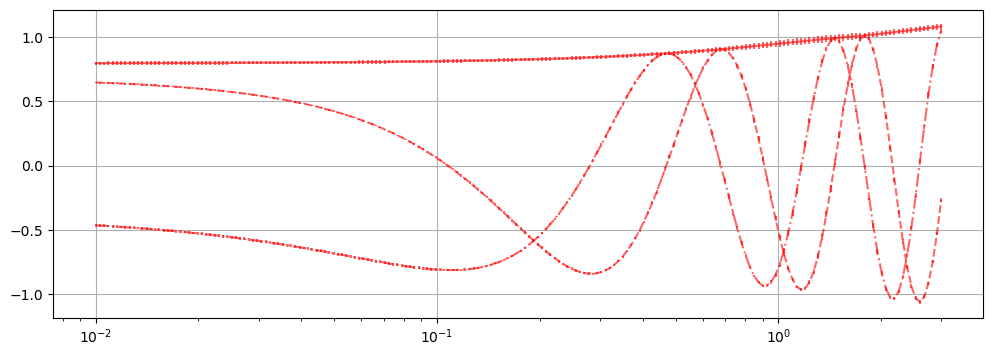

In [23]:
# Plotting
plt.figure(figsize=(12, 4))
# estimate
plt.errorbar(y1, jnp.real(Z), jnp.real(dZ), color='r', ls='--', alpha=0.6)
plt.errorbar(y1, jnp.imag(Z), jnp.imag(dZ), color='r', ls='-.', alpha=0.6)
plt.errorbar(y1, jnp.abs(Z) , jnp.abs(dZ) , color='r', ls='-' , alpha=0.6)
plt.xscale('log')
plt.grid()
plt.show()

# 2D

In [24]:
fresnel = Fresnel(ndim=2)
t = jnp.linspace(0, 0.4/w, 100)

priors = {'x':(-5,5,fresnel.ndim), 'y':(-5,5,fresnel.ndim), 'w':w}
sampler = plflow.HMCSampler(fresnel, priors)
sampler.sample(num_samples=10000, t=t)

sample: 100%|██████████| 10500/10500 [07:17<00:00, 23.98it/s, 63 steps of size 1.03e-01. acc. prob=0.84]


Removed no burn in


<Figure size 400x400 with 0 Axes>

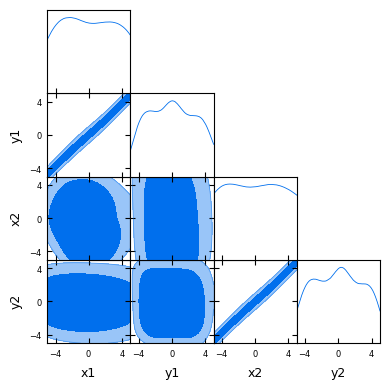

In [25]:
mcs = sampler.get_samples(format=MCSamples)

g = plots.get_single_plotter(ratio=1, width_inch=4)
g.triangle_plot(mcs, ['x1', 'y1', 'x2', 'y2'], filled=True)
plt.show()

## Normalizing flow training

Training MAF:  20%|█▉        | 198/1000 [00:24<01:39,  8.07it/s]

Early stopping at step 199 with best loss -0.807948112487793


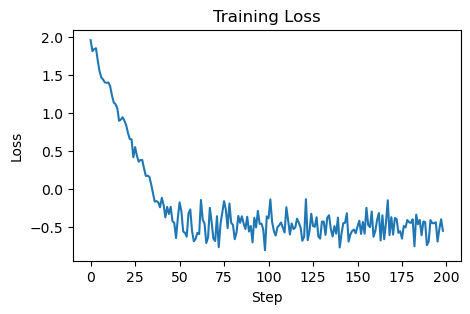

In [26]:
maf = plflow.MAFModel(sampler, process=True)

maf.build(hidden_dims=[32]*4, n_transforms=12)
maf.train(n_steps=1_000, batch_size=128, patience=100)
maf.plot_loss()

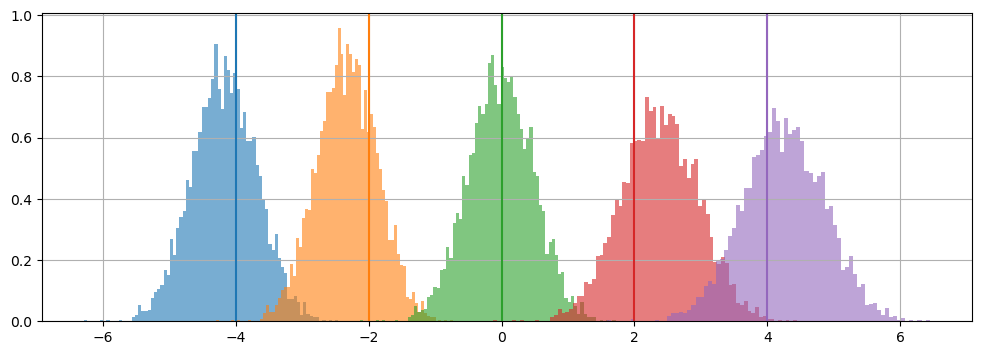

In [27]:
plt.figure(figsize=(12, 4))
for i, _y in enumerate([-4.0, -2.0, 0.0, 2.0, 4.0]):
    y   = jnp.array([_y]+[0.0]*(fresnel.ndim-1))
    x, lnp   = maf.sample_and_log_prob(y, num_samples=5000, seed=5)
    a = jnp.argsort(x[:,0])
    plt.hist(x[a,0], bins=80, density=True, color=f'C{i}', alpha=0.6)
    plt.axvline(y[0], color=f'C{i}')
plt.grid()
plt.show()

## Evaluate the integral

In [28]:
def perform(y, num_samples=1_000):
    x, lnp = maf.sample_and_log_prob(y, num_samples=num_samples, seed=0)
    Z, dZ  = fresnel.integrate(x, lnp, t, y=y, w=w, error=True)
    return Z, dZ
vperform = jax.vmap(perform, in_axes=0, out_axes=0)

In [30]:
y1 = jnp.logspace(-2, jnp.log10(10.0), 200)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2]*(fresnel.ndim-1), axis=1)
%time Z, dZ = vperform(y)

CPU times: user 1min 3s, sys: 6.26 s, total: 1min 10s
Wall time: 35.8 s


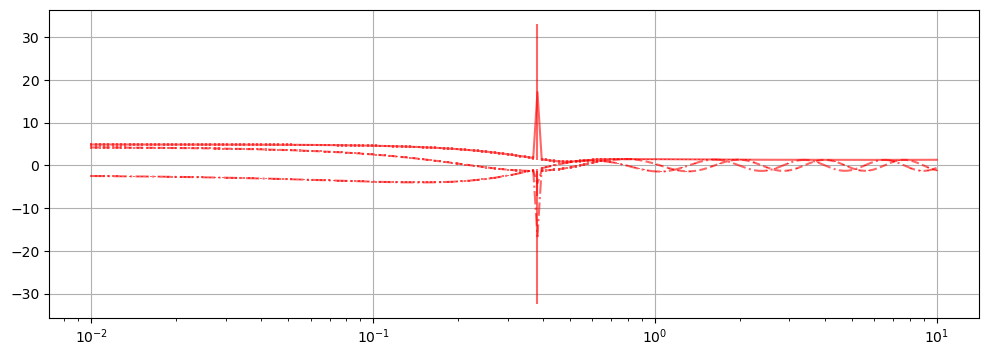

In [31]:
# Plotting
plt.figure(figsize=(12, 4))
# estimate
plt.errorbar(y1, jnp.real(Z), jnp.real(dZ), color='r', ls='--', alpha=0.6)
plt.errorbar(y1, jnp.imag(Z), jnp.imag(dZ), color='r', ls='-.', alpha=0.6)
plt.errorbar(y1, jnp.abs(Z) , jnp.abs(dZ) , color='r', ls='-' , alpha=0.6)
plt.xscale('log')
plt.grid()
plt.show()

In [32]:
sys.path.append('../')
import hypgeo

In [33]:
f_ana = hypgeo.F_amp_wave(y1,w)
f_est = Z * w/ (2*jnp.pi*1j)

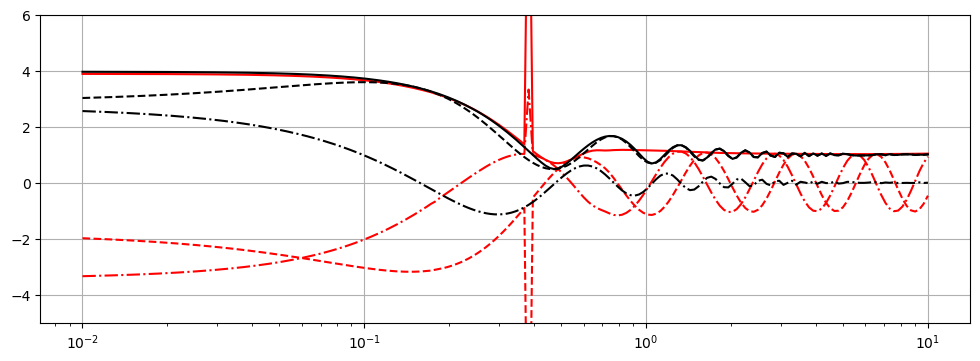

In [34]:
# Plotting
plt.figure(figsize=(12, 4))
# estimate
plt.plot(y1, jnp.real(f_est), color='r', ls='--')
plt.plot(y1, jnp.imag(f_est), color='r', ls='-.')
plt.plot(y1, jnp.abs(f_est) , color='r', ls='-')
# analytic
plt.plot(y1, jnp.real(f_ana), color='k', ls='--')
plt.plot(y1,-jnp.imag(f_ana), color='k', ls='-.')
plt.plot(y1, jnp.abs(f_ana) , color='k', ls='-')
plt.xscale('log')
plt.ylim(-5,6)
plt.grid()
plt.show()

In [35]:
w

5.0

In [36]:
y1.min(), y1.max()

(Array(0.01, dtype=float32), Array(9.999999, dtype=float32))

In [74]:
priors = {'x':(-5,5,fresnel.ndim), 'y':jnp.array([0.0, 0.0]), 'w':w}
sampler2 = plflow.HMCSampler(fresnel, priors)
sampler2.sample(num_samples=5000, t=t)

sample: 100%|██████████| 5500/5500 [01:37<00:00, 56.16it/s, 31 steps of size 1.67e-01. acc. prob=0.95] 


In [75]:
samples_dir = sampler2.get_samples(format=jnp.array, names=['x1', 'x2'])
samples_maf = maf.sample(jnp.array([0.0, 0.0]), num_samples=5000, seed=0)

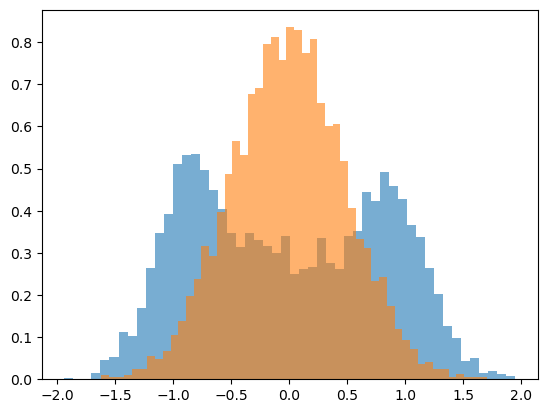

In [76]:
plt.hist(samples_dir[:,0], bins=50, density=True, alpha=0.6)
plt.hist(samples_maf[:,0], bins=50, density=True, alpha=0.6)
plt.show()